In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split

In [32]:
# Load files into dataframe object
train_img_dir = 'data_object_image_2/training/image_2/'
train_label_dir = 'data_object_image_2/training/label_2/'

images =  [(train_img_dir + f) for f in listdir(train_img_dir) if isfile(join(train_img_dir, f))]
images.sort()
labels = [(train_label_dir + f) for f in listdir(train_label_dir) if isfile(join(train_label_dir, f))]
labels.sort()

df = pd.DataFrame(np.column_stack([images, labels]), columns=['images', 'labels'])

In [33]:
df.head()

,images,labels
0,data_object_image_2/training/image_2/000000.png,data_object_image_2/training/label_2/000000.txt
1,data_object_image_2/training/image_2/000001.png,data_object_image_2/training/label_2/000001.txt
2,data_object_image_2/training/image_2/000002.png,data_object_image_2/training/label_2/000002.txt
3,data_object_image_2/training/image_2/000003.png,data_object_image_2/training/label_2/000003.txt
4,data_object_image_2/training/image_2/000004.png,data_object_image_2/training/label_2/000004.txt


In [34]:
df_train, df_val = train_test_split(df, test_size=0.5)

In [35]:
# Create mask for defined image (shows a map of what pixels contain a vehicle)
def create_mask(mask_directory, img_shape):
    mask = np.zeros(shape=(img_shape[0], img_shape[1], 1))
    with open(mask_directory) as f:
        content = f.readlines()
    contents = [x.split() for x in content]
    for content in contents:
        obj = content[0]
        if (obj in ['Car', 'Truck', 'Van']): # Get pixels containing a vehicle Tram?
            start_col = int(float(content[4]))
            start_row = int(float(content[5]))
            end_col = int(float(content[6]))
            end_row = int(float(content[7]))
            mask[start_row:end_row, start_col:end_col, 0] = 1
        # TODO: Also mark pedestrians/cyclist/person_sitting
#        elif (obj in ['Pedestrian', 'Cyclist', 'Person_sitting']):
#            start_col = int(float(content[4]))
#            start_row = int(float(content[5]))
#            end_col = int(float(content[6]))
#            end_row = int(float(content[7]))
#            mask[start_row:end_row, start_col:end_col, 0] = 2
    return mask

In [36]:
def create_images_generator(df_in, batch_size, resized_shape):
    batch_image = []
    batch_mask = []
    df_in_list = (df_in).values.tolist()
    np.random.shuffle(df_in_list)
    
    while True:
        for image_path, mask_path in df_in_list:
            image_r = cv2.imread(image_path)
            mask_r = create_mask(mask_path, image_r.shape)
            
            image_r = cv2.resize(image_r,(resized_shape[1], resized_shape[0]))
            mask_r = cv2.resize(mask_r,(resized_shape[1], resized_shape[0]))
            
            batch_image.append(image_r)
            batch_mask.append(mask_r)
            
            if len(batch_mask) >= batch_size:
                yield np.float32(np.stack((batch_image), 0)/255.0), np.stack(np.uint8(np.expand_dims(batch_mask, -1)), 0)
                batch_image, batch_mask = [], []

In [37]:
train_gen = create_images_generator(df_train, batch_size=64, resized_shape=(160, 256))
batch_img, batch_mask = next(train_gen)

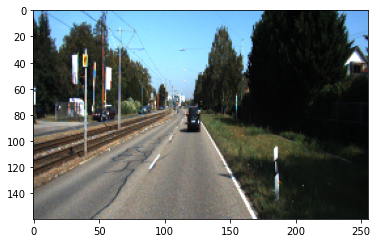

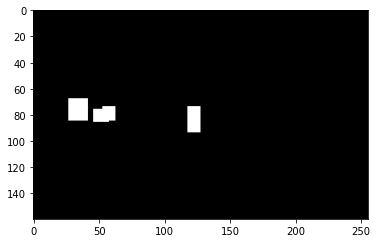

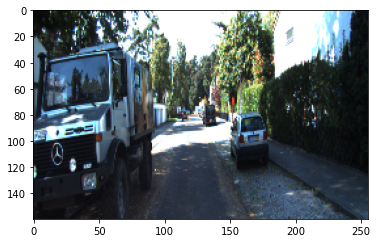

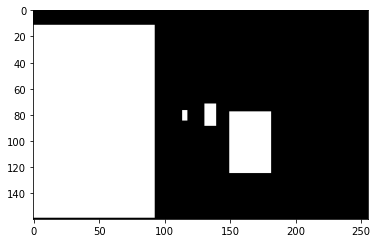

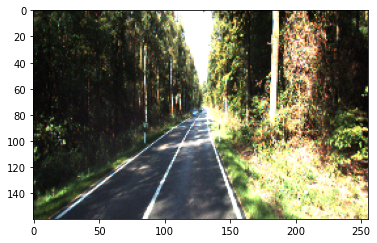

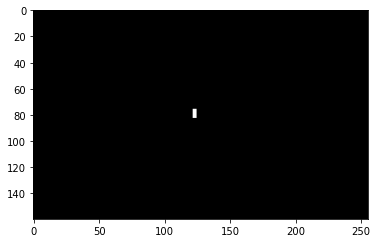

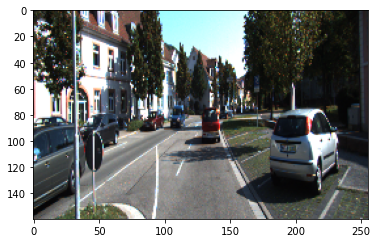

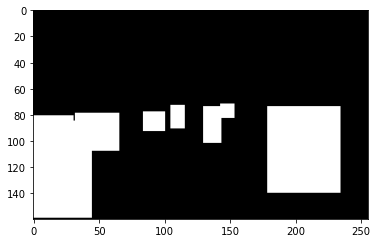

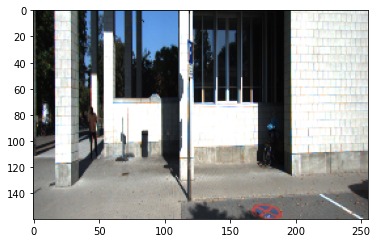

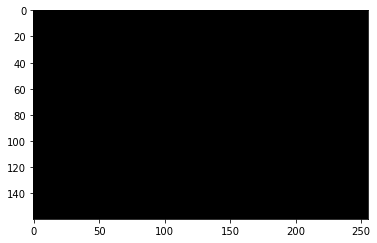

In [39]:
# See mask results
for i in range(5):
    im = np.array(255*batch_img[i], dtype=np.uint8)
    im_mask = np.array(batch_mask[i], dtype=np.uint8)
    
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.imshow(im_mask[:,:,0], cmap= 'gray')
    plt.show()